In [1]:
# GOAL
# "Given the pollutant data for a city on a given day, predict the AQI for that city."

In [2]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# Inputting the data

city_day = pd.read_csv("city_day.csv")

In [4]:
#Preprocessing

print("Before Preprocessing")
city_day.info()
city_day.dropna(subset=['AQI'], inplace=True)   # Drop all rows where no AQI, it is our prediction so can't be null

Before Preprocessing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


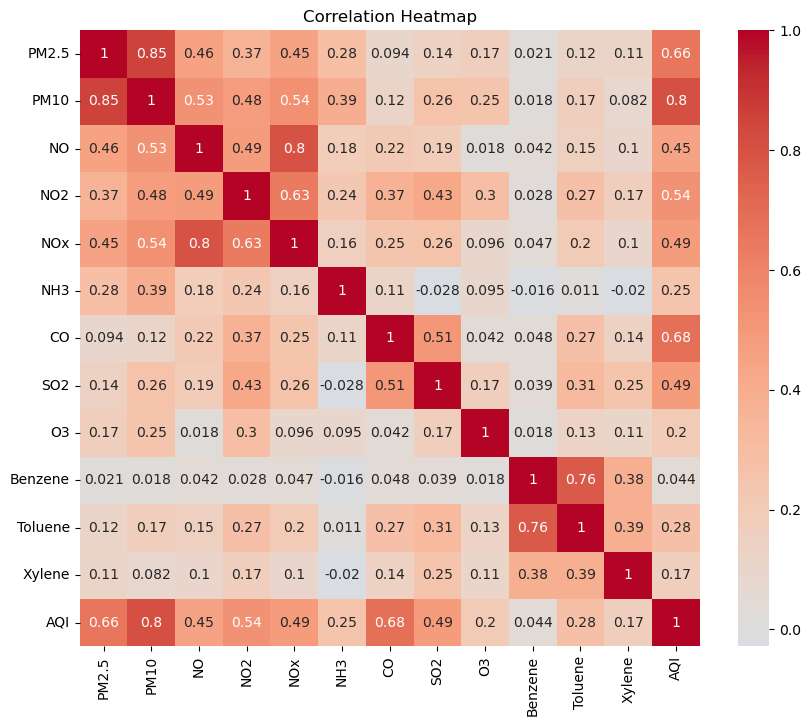

In [5]:
city_day.isnull().sum()
# Compute correlation matrix
corr_matrix = city_day.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

city_day.drop(columns=['PM2.5', 'NOx', 'Benzene', 'AQI_Bucket'], inplace=True) # Removing correlated variables for multicollinearity

# Drop Xylene, too many nulls-not high corr with prediction var
city_day.drop(columns=['Xylene', 'NO'], inplace=True)

# List of columns to fill
cols_to_fill = ['PM10', 'NO2', 'NH3', 'CO', 'SO2', 'O3', 'Toluene']

# First, sort by City and Date to ensure ffill works correctly
city_day.sort_values(by=['City', 'Date'], inplace=True)

# Apply forward-fill within each city
city_day[cols_to_fill] = city_day.groupby('City')[cols_to_fill].ffill()

#
# ---- The "Cleanup" Step ----
#
# ffill() might leave NaNs at the very *beginning* of a city's data
# (if the first few days were NaN).
#
# We can run a backward-fill (bfill) after to clean these up.
city_day[cols_to_fill] = city_day.groupby('City')[cols_to_fill].bfill()

city_day.dropna(inplace=True) # Now we can drop all redundant null rows

# Applying log transformation to deal with right skewed numerical data
city_day[city_day.select_dtypes(include=[np.number]).columns] = city_day.select_dtypes(include=[np.number]).apply(np.log1p)

# Creating Lag features
city_day.sort_values(by=['City', 'Date'], inplace=True)
city_day['AQI_lag_1'] = city_day.groupby('City')['AQI'].shift(1)  # Create a 1-day lag for AQI, grouped by city
city_day['PM10_lag_1'] = city_day.groupby('City')['PM10'].shift(1) # Create a 1-day lag for PM10, grouped by city
city_day.dropna(inplace=True) # Drop the new NaNs created by the shift()

# Converting City from categorical via One-hot encoding
city_day = pd.get_dummies(city_day, columns=['City'])

# Scaling the data
scaler = StandardScaler()
num_cols = city_day.select_dtypes(include=[np.number]).columns
city_day[num_cols] = scaler.fit_transform(city_day[num_cols])

# Feature Extraction from Date
city_day['Date'] = pd.to_datetime(city_day['Date'])
city_day['year'] = city_day['Date'].dt.year
city_day['month'] = city_day['Date'].dt.month
city_day['day_of_week'] = city_day['Date'].dt.dayofweek
city_day.drop(columns=['Date'], inplace=True)

In [6]:
print("After Preprocessing")
city_day.info()

# Save cleaned csv file
city_day.to_csv('preprocessed_city_day.csv', index=False)

After Preprocessing
<class 'pandas.core.frame.DataFrame'>
Index: 17369 entries, 2011 to 29530
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PM10                17369 non-null  float64
 1   NO2                 17369 non-null  float64
 2   NH3                 17369 non-null  float64
 3   CO                  17369 non-null  float64
 4   SO2                 17369 non-null  float64
 5   O3                  17369 non-null  float64
 6   Toluene             17369 non-null  float64
 7   AQI                 17369 non-null  float64
 8   AQI_lag_1           17369 non-null  float64
 9   PM10_lag_1          17369 non-null  float64
 10  City_Aizawl         17369 non-null  bool   
 11  City_Amaravati      17369 non-null  bool   
 12  City_Amritsar       17369 non-null  bool   
 13  City_Bengaluru      17369 non-null  bool   
 14  City_Chandigarh     17369 non-null  bool   
 15  City_Chennai        17369 non-null 